In [ ]:


from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_google_genai import GoogleGenerativeAI ,ChatGoogleGenerativeAI
import requests
import random
import warnings
warnings.filterwarnings("ignore")

import os

In [15]:
load_dotenv()

LLM = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  
    google_api_key=os.getenv('GOOGLE_API_KEY') )

In [12]:
# making the tools

search_tool = DuckDuckGoSearchRun(region ="us-en")


@tool
def calculator(first_num :float ,second_num:float,operation:str)->dict:

    """
    Perform basic arithmatic Operations on two numbers,
    Supported Operations : add ,substraction,multiply, Division
    
    """

    try:
        if operation =="add":
            result = first_num + second_num
        elif operation =="substraction":
            result =first_num - second_num
        elif operation =="multiply":
            result = first_num * second_num
        elif operation== "division":
            if second_num == 0:
                return{"error":"Division by zero is not allowed"}
            result = first_num/second_num
        else:
            return{'error':f"Unsupported Operation '{operation}'"}
        
        return {"first_num":first_num,"second_num":second_num,"operation":operation,"result":result}
    
    except Exception as e:
        return {'error':str(e)}






In [ ]:
#alpha_vantage _api key =" 8GVE9I888764Y2Z2"

In [11]:
# stock price seraching tool

@tool
def get_stock_price(symbol:str) ->dict:
    """
    Fetch latest stock prices for a given symbol(e.g "AAPL","TSLA")
    Using alpha vantage with api key in url
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=8GVE9I888764Y2Z2"
    r = requests.get(url)
    return r.json()

In [16]:
#tool ode set up

tools = [get_stock_price,search_tool,calculator]

#intyegrate llm with tools
llm_with_tools = LLM.bind_tools(tools)


In [18]:
#declare state

class chatstate(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [19]:
def chat_node(state:chatstate)->chatstate:

    """
    LLM node may answer or request a tool
    
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]}

tool_node = ToolNode(tools)

In [20]:
#graph nodes



# graph structure
graph = StateGraph(chatstate)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)



In [21]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")    

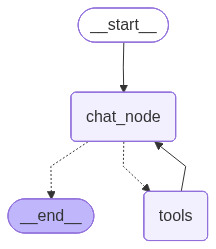

In [22]:
chatbot = graph.compile()
chatbot

In [23]:


# Regular chat
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)



Hello! How can I help you today?


In [25]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 14 million 4 thousand times 5999999?")]})
print(out["messages"][-1].content)

The product of 14,004,000 and 5,999,999 is 84,023,985,996,000.


In [26]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of Amazon")]})
print(out["messages"][-1].content)

The stock price of Amazon (AMZN) is $215.57.


In [29]:


# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Nvdia using get stock price tool  and tell me ,then use the calculator tool to find out how much will it take to purchase 100 shares?")]})
print(out["messages"][-1].content)



The current stock price of Nvidia is 179.83. To purchase 100 shares, it would cost 17983.


In [31]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="Weather in kolkata now?")]})
print(out["messages"][-1].content)

Kolkata is expected to have a sunny and warm day today, October 16, with temperatures reaching 31.1Â°C. The humidity is at 66% and wind speeds are 18 kph. There's a slight chance of afternoon showers which might improve the air quality.


In [34]:
from langchain_core.messages import AIMessage

In [ ]:
def chat_with_tools(user_input):
    """"""
    out = chatbot.invoke({"messages": [HumanMessage(content=user_input)]})
    
    # Check which tools were used
    tools_used = []
    for msg in out["messages"]:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tool_call in msg.tool_calls:
                tools_used.append(tool_call['name'])
    
    # Print results
    if tools_used:
        print(f"ðŸ”§ Tools Used: {', '.join(tools_used)}")
    print(f"âœ… Answer: {out['messages'][-1].content}\n")
    
    

In [38]:
# Test 1: Calculator
chat_with_tools("What is 14 million times 6 million?")

ðŸ”§ Tools Used: calculator
âœ… Answer: 14 million times 6 million is 84,000,000,000,000.



In [39]:
# Test 2: Stock price
chat_with_tools("What is the stock price of Amazon?")

ðŸ”§ Tools Used: get_stock_price
âœ… Answer: The stock price of Amazon (AMZN) is $215.57.



In [40]:
# Test 3: Multiple tools
chat_with_tools("Find Nvidia stock price and calculate cost for 100 shares")

ðŸ”§ Tools Used: get_stock_price, calculator
âœ… Answer: The current stock price of Nvidia is $179.83. 100 shares would cost $17983.



In [41]:
# Test 4: Web search
chat_with_tools("Weather in Kolkata now?")


ðŸ”§ Tools Used: duckduckgo_search
âœ… Answer: The weather in Kolkata today, October 16, is sunny and warm with temperatures reaching 31.1Â°C. There were heavy showers and thunder on Friday afternoon.



In [ ]:
chat_with_tools("Tell me about Artificial Intelliogence?")

ðŸ”§ Tools Used: duckduckgo_search
âœ… Answer: Artificial intelligence (AI) is a field that enables computers and machines to perform tasks that typically require human intelligence. This includes abilities like reasoning, discovering meaning, generalizing, and learning from past experiences.

AI is a powerful and rapidly evolving technology that is transforming industries and shaping the future. It works through various methods such as machine learning, deep learning, and neural networks, allowing systems to learn from data, recognize patterns, and make decisions to solve complex problems.

AI has a wide range of applications across many industries, including:
*   **Healthcare:** For diagnostics, personalized treatment plans, and drug discovery.
*   **Finance:** For fraud detection, algorithmic trading, and personalized financial advice.
*   **E-commerce:** For personalized recommendations and customer service.
*   **Transportation:** Enabling self-driving cars and optimizing logistic

: 